# Uso de modelos cuantizados
Los modelos pre-entrenados de OpenVINO vienen ya cuantizados, por lo que son una parte importante para desarrollar una aplicación mas ligera, por lo general, los archivos descargados por el model downloader vienen con las  tres configuraciones de precisión `FP32`, `FP16`, `FP16-INT8` listas y compatibles con el Motor de Inferencia de Intel. En el presente Notebook se ejecutan la inferencia para un modelo de detección de género y edad: 

## Inicializar las variables de Entorno
Como siempre, hay que inicializar las variables de entorno de OpenVINO, por favor **ejecutar** la celda correspondiente: 
- *Windows*

In [ ]:
%%cmd
"C:\Program Files (x86)\Intel\openvino_2021\bin\setupvars.bat"

- *Linux*

In [1]:
%%bash
source /opt/intel/openvino_2021/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


## Descargar el archivo de ejemplo de detección de edad (si es que no ha sido descargado aún)
El modelo a descargar es el `age-gender-recognition-retail-0013` del OpenVINO Model Zoo, que detecta la edad con un error de edad aproximado de 6.99 años con una precisión de detección de género de 95.80%.[1]

In [2]:
import os, sys
nombre_modelo = "age-gender-recognition-retail-0013 "
ruta_archivo = os.getcwd()
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

if (not os.path.isfile(ruta_modelo_xml)) and (not os.path.isfile(ruta_modelo_bin)):
    if sys.platform == "win32":
        ruta_model_downloader="C:\Program Files (x86)\Intel\openvino_2021\deployment_tools\tools\model_downloader\downloader.py"
        !python {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
    elif sys.platform == "linux":
        ruta_model_downloader="/opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py"
        !python3 {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
else:
    print("Archivos actualmente descargados en {}{}".format(ruta_archivo, ruta_modelo_xml))

################|| Downloading age-gender-recognition-retail-0013 ||################

========== Downloading /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 5/intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml
... 100%, 30 KB, 204 KB/s, 0 seconds passed

========== Downloading /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 5/intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.bin
... 100%, 8351 KB, 465 KB/s, 17 seconds passed

========== Downloading /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 5/intel/age-gender-recognition-retail-0013/FP16/age-gender-recognition-retail-0013.xml
... 100%, 30 KB, 510 KB/s, 0 seconds passed

========== Downloading /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 5/intel/age-gender-recognition-retail-0013/FP16/age-gender-recognition-retail-0013.bin
... 100%, 4175 KB, 470 KB/s, 8 seconds passed

========== Downloading /home/josejacomeb/Document

## Uniendo todo
El anterior ejemplo de esta sección, se une en dos funciones para poder llamarlas en las siguientes celdas de código. 
**Nota:** En caso de no poder ejecutar el código anterior, desde el CMD de Windows o Terminal de Linux, primero inicializar las variables de entorno en el terminal y luego ejecutar el Jupyter Notebook.


### Cargar una imagen de ejemplo

Forma del vector de entrada: (251, 198, 3)
Forma del vector de entrada: (251, 198, 3)


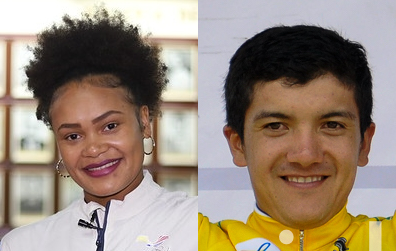

In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

imagen_hombre = cv2.imread("Imágenes/richard.jpg")
imagen_mostrar_hombre = cv2.cvtColor(imagen_hombre, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
imagen_mujer = cv2.imread("Imágenes/neisi.jpg")
imagen_mostrar_mujer = cv2.cvtColor(imagen_mujer, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
ancho, alto = imagen_mostrar_hombre.shape[0:2]
imagen_mostrar_mujer = cv2.resize(imagen_mostrar_mujer, (alto, ancho))
print("Forma del vector de entrada: {}".format(imagen_hombre.shape))
print("Forma del vector de entrada: {}".format(imagen_mujer.shape))
imagen_mostrar = np.concatenate((imagen_mostrar_mujer, imagen_mostrar_hombre), axis=1)
display(Image.fromarray(imagen_mostrar)) 


### Realizar una función para cargar el modelo

In [2]:
#Cargar las clases de IECore, IENetwork
from openvino.inference_engine import IECore
import time #Medir el tiempo de carga

def cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia):
    inicio_tiempo = time.time()
    ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

    core = IECore() #Inicializo el objeto IECore
    """
    Inicializo el objeto de tipo IENetwork a 
    través de la función core.read_network
    """
    network = core.read_network(model=ruta_modelo_xml, weights=ruta_modelo_bin) 

    resultado_capas = core.query_network(network, nombre_dispositivo_inferencia)
    capas_no_soportadas = ""
    for capa, dispositivo in resultado_capas.items():
        if dispositivo != nombre_dispositivo_inferencia:
            capas_no_soportadas += capa
            capas_no_soportadas += '\n'
    if capas_no_soportadas:
        print("Capas no soportadas para el dispositivo: {}\n {}".format(dispositivo, capas_no_soportadas))
        print("Se recomienda verificar en los demás dispositivos y hacer una ejecución heterogénea")
    else:
        print("Todas las capas están soportadas por el dispositivo: {}".format(nombre_dispositivo_inferencia))
    exec_network = core.load_network(network, nombre_dispositivo_inferencia) #Objeto de tipo ExecutableNetwork
    tiempo_final = time.time() - inicio_tiempo
    return exec_network, core, network, tiempo_final;

### Definición de la función para ajustar a la entrada del vector

In [3]:
import numpy as np
def preparar_array_entrada(imagen, forma_vector_entrada):
    #Formato OPENCV: H, W, C
    #Formato Capa Entrada: B, C, H, W
    imagen_correcta_alto_ancho = (forma_vector_entrada[3], forma_vector_entrada[2]) 
    imagen_correcta_entrada = cv2.resize(imagen, imagen_correcta_alto_ancho) #Resize argumento (W, H)
    imagen_correcta_entrada = np.transpose(imagen_correcta_entrada, (2, 0, 1))
    imagen_correcta_entrada = np.reshape(imagen_correcta_entrada, tuple(forma_vector_entrada))
    return imagen_correcta_entrada

### Definición de la función para graficar los resultados

In [4]:
import numpy as np
def dibujar_edad_sexo(imagen, resultado_inferencia):
    #Debido que la forma del resultado es 1, 1, N, 7
    imagen_resultado = imagen.copy()
    nombre_capa_edad = "age_conv3" # De la docmentacion
    nombre_capa_genero = "prob"
    vector_genero = ["hombre", "mujer"]
    edad = resultado_inferencia[nombre_capa_edad].buffer.flatten()[0]*100
    genero = vector_genero[resultado_inferencia[nombre_capa_genero].buffer.flatten().argmax()]
    x1, y1 = 10, 20
    y2 = 2*y1
    amarillo = (11,223,253)
    verde = (33,166,96)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.65
    thickness = 2
    imagen_resultado = cv2.putText(imagen_resultado, "Edad: {:.2f}".format(edad), (x1, y1), font, fontScale, verde, thickness, cv2.LINE_AA)
    imagen_resultado = cv2.putText(imagen_resultado, "Genero: {}".format(genero), (x1, y2), font, fontScale, amarillo, thickness, cv2.LINE_AA)
    return imagen_resultado     

### Función Inferencia Asíncrona

In [5]:
def inferencia_asincrona(exec_network, network, imagen_corregida):
    nombre_capa_entrada = next(iter(network.input_info))
    forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
    nombre_capa_salida = next(iter(network.outputs))
    tiempo_inicio = time.time()
    #Inicia la inferencia asincrona
    estado_inferencia_handler = exec_network.start_async(request_id = 0, inputs = {nombre_capa_entrada: imagen_corregida}) #Enviar como diccionario con el nombre de la capa de entrada
    #Espera hasta que este listo el resultado
    estado_inferencia = estado_inferencia_handler.wait()
    #Recibe el resultado
    resultado = estado_inferencia_handler.output_blobs
    tiempo_final = time.time() - tiempo_inicio
    return resultado, tiempo_final;

## Inferencia Asíncrona con modelos Cuantizados
En este ejemplo, se medirá los tiempos de la inferencia asíncrona en un GPU con varias precisiones de modelo, se mostrará que la precisión no decae y que la inferencia y la carga es más rápida.
### Resultados Inferencia Síncrona en un modelo FP32 en GPU

Todas las capas están soportadas por el dispositivo: GPU
Tiempo de carga: 5.219740152359009
Tiempo promedio de procesamiento: 0.0013
Tiempo total de procesamiento: 0.0025


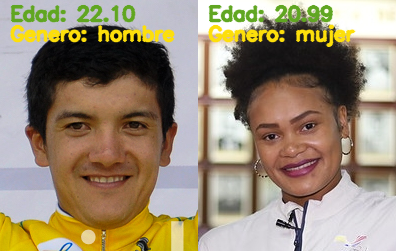

In [8]:
ruta_modelo_xml = "intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml"
nombre_dispositivo_inferencia="GPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
tiempo_total = 0
imagen_vector_entrada_hombre = preparar_array_entrada(imagen_hombre, forma_capa_entrada)
imagen_vector_entrada_mujer = preparar_array_entrada(imagen_mujer, forma_capa_entrada)
resultado_hombre, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_hombre)
tiempo_total += tiempo_procesamiento
resultado_mujer, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_mujer)
resultado_hombre = dibujar_edad_sexo(imagen_hombre, resultado_hombre)
resultado_mujer= dibujar_edad_sexo(imagen_mujer, resultado_mujer)
imagen_mostrar_procesada = np.concatenate((resultado_hombre, resultado_mujer), axis=1)
print("Tiempo de carga: {}".format(tiempo_carga))
print("Tiempo promedio de procesamiento: {:.4f}".format(tiempo_total/2))
print("Tiempo total de procesamiento: {:.4f}".format(tiempo_total))
display(Image.fromarray(cv2.cvtColor(imagen_mostrar_procesada, cv2.COLOR_BGR2RGB))) 

### Resultados Inferencia Síncrona en un modelo FP16 en GPU

Todas las capas están soportadas por el dispositivo: GPU
Tiempo de carga: 5.619837760925293
Tiempo promedio de procesamiento: 0.0009
Tiempo total de procesamiento: 0.0019


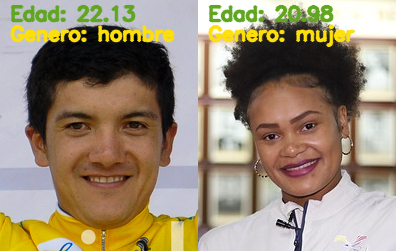

In [9]:
ruta_modelo_xml = "intel/age-gender-recognition-retail-0013/FP16/age-gender-recognition-retail-0013.xml"
nombre_dispositivo_inferencia="GPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
tiempo_total = 0
imagen_vector_entrada_hombre = preparar_array_entrada(imagen_hombre, forma_capa_entrada)
imagen_vector_entrada_mujer = preparar_array_entrada(imagen_mujer, forma_capa_entrada)
resultado_hombre, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_hombre)
tiempo_total += tiempo_procesamiento
resultado_mujer, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_mujer)
resultado_hombre = dibujar_edad_sexo(imagen_hombre, resultado_hombre)
resultado_mujer= dibujar_edad_sexo(imagen_mujer, resultado_mujer)
imagen_mostrar_procesada = np.concatenate((resultado_hombre, resultado_mujer), axis=1)
print("Tiempo de carga: {}".format(tiempo_carga))
print("Tiempo promedio de procesamiento: {:.4f}".format(tiempo_total/2))
print("Tiempo total de procesamiento: {:.4f}".format(tiempo_total))
display(Image.fromarray(cv2.cvtColor(imagen_mostrar_procesada, cv2.COLOR_BGR2RGB))) 

### Resultados Inferencia asíncrona en un modelo INT8 en GPU

Todas las capas están soportadas por el dispositivo: GPU
Tiempo de carga: 6.916740417480469
Tiempo promedio de procesamiento: 0.0011
Tiempo total de procesamiento: 0.0022


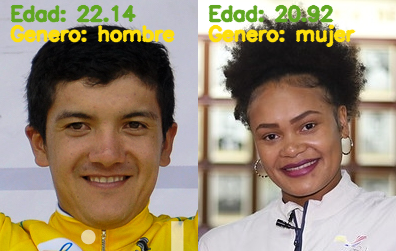

In [10]:
ruta_modelo_xml = "intel/age-gender-recognition-retail-0013/FP16-INT8/age-gender-recognition-retail-0013.xml"
nombre_dispositivo_inferencia="GPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
tiempo_total = 0
imagen_vector_entrada_hombre = preparar_array_entrada(imagen_hombre, forma_capa_entrada)
imagen_vector_entrada_mujer = preparar_array_entrada(imagen_mujer, forma_capa_entrada)
resultado_hombre, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_hombre)
tiempo_total += tiempo_procesamiento
resultado_mujer, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada_mujer)
resultado_hombre = dibujar_edad_sexo(imagen_hombre, resultado_hombre)
resultado_mujer= dibujar_edad_sexo(imagen_mujer, resultado_mujer)
imagen_mostrar_procesada = np.concatenate((resultado_hombre, resultado_mujer), axis=1)
print("Tiempo de carga: {}".format(tiempo_carga))
print("Tiempo promedio de procesamiento: {:.4f}".format(tiempo_total/2))
print("Tiempo total de procesamiento: {:.4f}".format(tiempo_total))
display(Image.fromarray(cv2.cvtColor(imagen_mostrar_procesada, cv2.COLOR_BGR2RGB))) 

Como se puede observar, hay una ligera disminución del tiempo de carga del modelo en precisiones de `FP16` y `FP16-INT8`, además los tiempos de inferencia también bajan unos cuantos milisegundos sin perder la precisión del modelo.

## Referencias
- [1] Intel. (2021, Agosto 31).age-gender-recognition-retail-0013. Intel. [https://docs.openvinotoolkit.org/2019_R1/_age_gender_recognition_retail_0013_description_age_gender_recognition_retail_0013.html](https://docs.openvinotoolkit.org/2019_R1/_age_gender_recognition_retail_0013_description_age_gender_recognition_retail_0013.html)